In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA  , EliteIslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies

In [36]:
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())
ga = IslandGGA(data=train_data,num_islands=3,m_iter=40,num_iter=80,n_migrants=100,pSize=200,r_cross=0.01,r_mut=0.0001,strategies=strategies,evolve_strategy="nearest")

In [37]:
ga.evolve()

Running nearest
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0


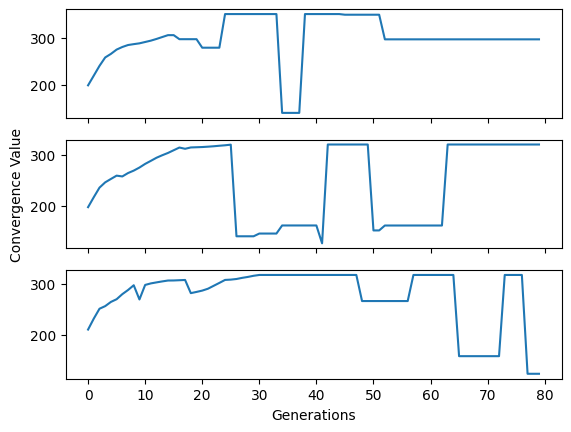

In [38]:
import matplotlib.pyplot as plt

global_list =ga.convergence_values

if all(isinstance(item, list) for item in global_list):
    global_list = [i[:3] for i in global_list]
    
    num_variables = len(global_list[0])
    num_timesteps = len(global_list)

    # Create subplots for each variable
    fig, axes = plt.subplots(num_variables, 1, sharex=True)

    # Plot each variable on its corresponding subplot
    for var_index in range(num_variables):
        var_data = [global_list[i][var_index] for i in range(num_timesteps)]
        axes[var_index].plot(var_data)

    # Add x and y labels to the last subplot
    axes[num_variables-1].set_xlabel('Generations')
    axes[num_variables//2].set_ylabel('Convergence Value')

    # Display the plot
    plt.show()
else:
    cols = ["Convergence"]
    df = pd.DataFrame(np.column_stack([ga.convergence_values]), columns=cols)
    df.plot()



<AxesSubplot: >

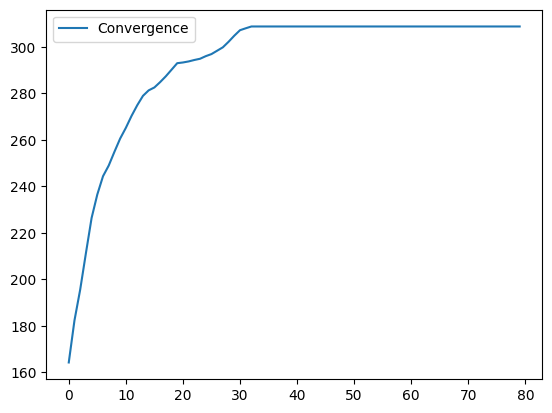

In [25]:
con =ga.convergence_values
#con = [i[2] for i in ga.convergence_values]
cols = ["Convergence"]
df = pd.DataFrame(np.column_stack([con]), columns=cols)
df.plot()

In [58]:

values = []
crossover_rates = [0.0001,0.001,0.003,0.005,0.01]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=40,num_iter=80,n_migrants=100,pSize=200,r_cross=i,r_mut=0.0001,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(ga.convergence_values)
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']

#df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
    #                           columns=cols)


#print(df.describe())

#df_1 =df_1.dropna(axis = 0)
#df.plot(kind='box')

Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0


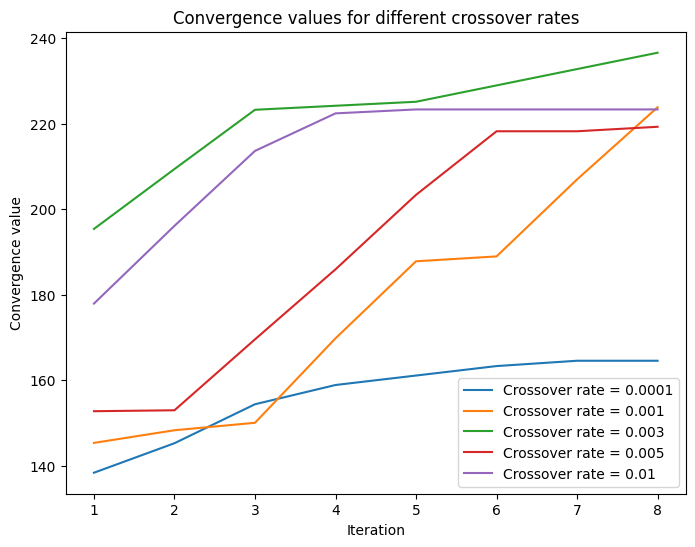

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# convergence values for each crossover rate
crossover_rates = [0.0001,0.001,0.003,0.005,0.01]
convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 9), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()



In [ ]:
p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    ring[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_ring.append(ring[i].fitness_value)
    master[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_master.append(master[i].fitness_value)
    multi[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_multi.append(multi[i].fitness_value)
    gga[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_gga.append(gga[i].fitness_value)
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']
#cols_1 = ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
                               columns=cols)
#df_1 = df[cols_1]

#df_1 = df_1[df[cols_1] < 100000]
#print(df_1.isna().sum())
#df_1 =df_1.dropna(axis = 0)
df.describe()
#df.plot(kind='box')